## RuDOLPH 350M finetuning

пример кода взят отсюда: https://github.com/ai-forever/ru-dolph

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DL memes/meme-captions

/content/drive/MyDrive/DL memes/meme-captions


In [ ]:
!pip install rudolph==0.0.1rc8 > /dev/null
!pip install bitsandbytes-cuda111 > /dev/null
!pip install wandb > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
import sys
import random
from collections import Counter

import PIL
import torch
import numpy as np
import pandas as pd
import bitsandbytes as bnb
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm import tqdm
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from rudalle import get_tokenizer, get_vae
from rudalle.utils import seed_everything

from rudolph.model.utils import get_attention_mask
from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph.pipelines import generate_codebooks, self_reranking_by_image, self_reranking_by_text, show, generate_captions, generate_texts, zs_clf
from rudolph import utils

# Загрузка модели и параметров

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_rudolph_model('350M',  fp16=True, device=device)
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

Downloading:   0%|          | 0.00/707M [00:00<?, ?B/s]

Russian Diffusion On Language Picture Hyper-modality (RuDOLPH 🦌🎄☃️) 350M is a fast and light text-image-text transformer (350M GPT-3) designed for a quick and easy fine-tuning setup for the solution of various tasks: from generating images by text description and image classification to visual question answering and more. 
This model demonstrates the power of Hyper-modality Transformers.


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

vae --> ready


In [ ]:
class Args():
    def __init__(self, model):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 20
        self.save_path='models/rudolph/'
        self.model_name = 'rudolph_'
        self.save_every = 1
        self.bs = 5
        self.clip = 1.0
        self.lr = 2e-5
        self.wandb = False
        self.lt_loss_weight = 0.01
        self.img_loss_weight = 1
        self.rt_loss_weight = 7
        self.image_size = self.image_tokens_per_dim * 8

args = Args(model)
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

# Подготовка данных

In [ ]:
class Data(Dataset):
    def __init__(self, image_path, data_path, tokenizer, shuffle=True):
        self.image_path = image_path
        self.samples = []
        self.tokenizer = tokenizer
        # загружаем id картинок и их captions
        with open(data_path, 'r') as f:
            f.readline()
            for line in f:
                uid, caption = line.strip().split('\t')
                self.samples.append([f"{uid}.jpg", caption])

        self.image_transform = T.Compose([
            T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
            T.Resize((args.image_size, args.image_size)),
            T.ToTensor()
        ])


        if shuffle:
            np.random.shuffle(self.samples)
            print('Shuffled')

    def load_image(self, img_name):
        return PIL.Image.open(os.path.join(self.image_path, img_name))

    def __getitem__(self, item):
        item = item % len(self.samples)
        img_name, text = self.samples[item]

        try:
            image = self.load_image(img_name)
            image = self.image_transform(image)
        except Exception as err:  
            print(err)
            random_item = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(random_item)
        
        text = text.lower().strip()
        encoded = self.tokenizer.encode_text(text, text_seq_length=args.r_text_seq_length)       
        return encoded, image

    def get_text_image(self, item):
        item = item % len(self.samples)
        img_name, text = self.samples[item]
        image = self.load_image(img_name)
        image = self.image_transform(image)
        text = text.lower().strip()
        return text, image

    def __len__(self):
        return len(self.samples)

In [ ]:
train_dataset = Data(image_path='data/memes/images/', data_path='data/memes/train.csv', tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=args.bs, shuffle=True, drop_last=True)

val_dataset = Data(image_path='data/memes/images/', data_path='data/memes/val.csv', tokenizer=tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=args.bs, shuffle=False, drop_last=True)

Shuffled
Shuffled


# Обучение моделей

Обучаю в течение 20 эпох, сохраняю модель с наименьшим лоссом на валидационном датасете


In [ ]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
):
    for name, p in model.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [ ]:
model.train()
optimizer = bnb.optim.Adam8bit(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=args.lr, final_div_factor=500, 
    steps_per_epoch=len(train_dataloader), epochs=args.epochs 
)

In [ ]:
def train(model,args: Args, train_dataloader, val_dataloader):

    torch.save(model.state_dict(), 
           os.path.join(args.save_path, 
                        f"{args.model_name}_dalle_{0}.pt"))
    train_loss_logs = []
    val_loss_logs = []
    
    best_val_loss = 1000
    best_val_model_id = None


    for epoch in range(args.epochs):

        cur_train_loss = 0

        # эпоха обучения
        for text, images in tqdm(train_dataloader):

            model.train()
            model.zero_grad()
            total_seq_length = args.l_text_seq_length + args.image_seq_length + args.r_text_seq_length
        
            masks = torch.ones(args.bs, args.r_text_seq_length, dtype=torch.int32)
            attention_mask = get_attention_mask(masks, args.bs, args.l_text_seq_length, args.image_tokens_per_dim,
                                                    args.r_text_seq_length, device)
            image_input_ids = vae.get_codebook_indices(images.to(device))
            r_text = text.to(device)
            l_text = torch.zeros((args.bs, args.l_text_seq_length), device=device, dtype=torch.long)
            input_ids = torch.cat((l_text, image_input_ids, r_text), dim=1)
            loss, loss_values = model.forward(input_ids, attention_mask, lt_loss_weight=args.lt_loss_weight,
            img_loss_weight=args.img_loss_weight,rt_loss_weight=args.rt_loss_weight,  return_loss=True)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            cur_train_loss += loss.item()
        


        cur_val_loss = 0
        # оценка на вал. датасете
        for text, images in tqdm(val_dataloader):
        
            model.eval()
            total_seq_length = args.l_text_seq_length + args.image_seq_length + args.r_text_seq_length
        
            masks = torch.ones(args.bs, args.r_text_seq_length, dtype=torch.int32)
            attention_mask = get_attention_mask(masks, args.bs, args.l_text_seq_length, args.image_tokens_per_dim,
                                                    args.r_text_seq_length, device)
            image_input_ids = vae.get_codebook_indices(images.to(device))
            r_text = text.to(device)
            l_text = torch.zeros((args.bs, args.l_text_seq_length), device=device, dtype=torch.long)
            input_ids = torch.cat((l_text, image_input_ids, r_text), dim=1)
            loss, loss_values = model.forward(input_ids, attention_mask, lt_loss_weight=args.lt_loss_weight,
            img_loss_weight=args.img_loss_weight,rt_loss_weight=args.rt_loss_weight,  return_loss=True)

            cur_val_loss += loss.item()
        

        cur_val_loss /= len(val_dataloader)
        cur_train_loss /= len(train_dataloader)
        train_loss_logs += [cur_train_loss]
        val_loss_logs += [cur_val_loss]
            
        if cur_val_loss < best_val_loss:
                print(f'Saving checkpoint here {args.model_name}_dalle_best.pt')
                plt.plot(train_loss_logs)
                plt.plot(val_loss_logs)
                plt.show()
                torch.save(
                    model.state_dict(),
                    os.path.join(args.save_path,f"{args.model_name}_dalle_best.pt")
                )
                best_val_loss = cur_val_loss

        print(f"Epoch {epoch+1}, train_loss:{cur_train_loss}, val_loss:{cur_val_loss}")
            
    
    print(f'Complitly tuned and saved here  {args.model_name}__dalle_last.pt')
    plt.plot(train_loss_logs)
    plt.plot(val_loss_logs)
    plt.show()
    torch.save(
        model.state_dict(),
        os.path.join(args.save_path,f"{args.model_name}dalle_last.pt")
    )

100%|██████████| 109/109 [04:44<00:00,  2.61s/it]

Saving checkpoint here rudolph__dalle_best.pt


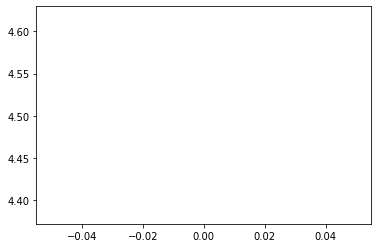

Epoch 1, train_loss:4.617974362813653, val_loss:4.383404263662635


100%|██████████| 109/109 [00:34<00:00,  3.15it/s]

Saving checkpoint here rudolph__dalle_best.pt


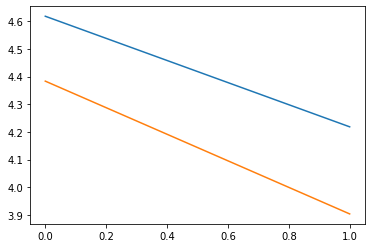

Epoch 2, train_loss:4.218300536011432, val_loss:3.9034687750930086


100%|██████████| 109/109 [00:34<00:00,  3.15it/s]

Saving checkpoint here rudolph__dalle_best.pt


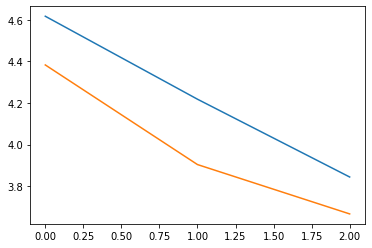

Epoch 3, train_loss:3.8435416910175255, val_loss:3.665717431164663


100%|██████████| 109/109 [00:34<00:00,  3.15it/s]

Saving checkpoint here rudolph__dalle_best.pt


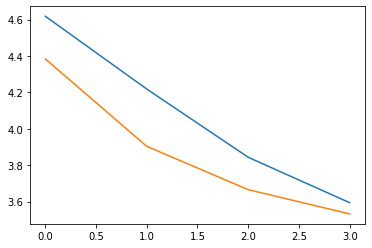

Epoch 4, train_loss:3.59428143922847, val_loss:3.5326745575721112


100%|██████████| 109/109 [00:34<00:00,  3.11it/s]

Saving checkpoint here rudolph__dalle_best.pt


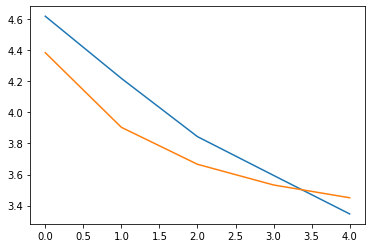

Epoch 5, train_loss:3.346517181115441, val_loss:3.4504163921426194


100%|██████████| 109/109 [00:34<00:00,  3.15it/s]

Saving checkpoint here rudolph__dalle_best.pt


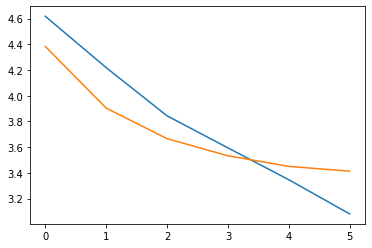

Epoch 6, train_loss:3.080585101732805, val_loss:3.4127522980401275


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]

Saving checkpoint here rudolph__dalle_best.pt


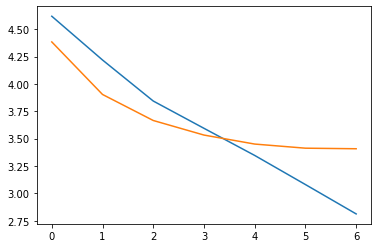

Epoch 7, train_loss:2.812371204316265, val_loss:3.4076201478275685


100%|██████████| 109/109 [00:34<00:00,  3.13it/s]


Epoch 8, train_loss:2.5591568127128137, val_loss:3.4336821267364224


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]


Epoch 9, train_loss:2.340381575708071, val_loss:3.4576070549291207


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]


Epoch 10, train_loss:2.1379116553454596, val_loss:3.5006224387282625


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]


Epoch 11, train_loss:1.9645770155844848, val_loss:3.554614681716359


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]


Epoch 12, train_loss:1.819908956413419, val_loss:3.5991480547353762


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]


Epoch 13, train_loss:1.7003789196314183, val_loss:3.638018487790309


100%|██████████| 109/109 [00:34<00:00,  3.13it/s]


Epoch 14, train_loss:1.6121855264562521, val_loss:3.6633253447506404


100%|██████████| 109/109 [00:34<00:00,  3.12it/s]


Epoch 15, train_loss:1.5475498641638015, val_loss:3.680401215859509


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]


Epoch 16, train_loss:1.5097069431147547, val_loss:3.6942308649010616


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]


Epoch 17, train_loss:1.4888790583563694, val_loss:3.69322248336372


100%|██████████| 109/109 [00:34<00:00,  3.15it/s]


Epoch 18, train_loss:1.4802791011356886, val_loss:3.6958561381068797


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]


Epoch 19, train_loss:1.475737204251917, val_loss:3.696475466456982


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]

Epoch 20, train_loss:1.475519789693866, val_loss:3.696930999055915
Complitly tuned and saved here  rudolph___dalle_last.pt


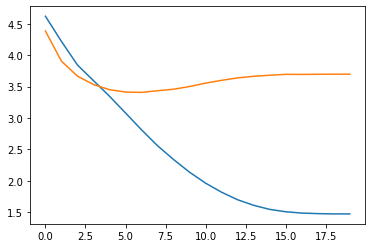

In [ ]:
model = freeze(
    model=model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
) 

train(model, args, train_dataloader, val_dataloader)

лучшая по лоссу на вал.датасете модель после 6 эпохи

## Evaluation на тестовом датасете 

In [66]:
import datetime
import more_itertools
import transformers

def generate_captions(
        img,
        tokenizer,
        model,
        vae,
        template='',
        top_k=32, top_p=0.6, captions_num=128,
        temperature=1.0, bs=64,
        seed=None, use_cache=True,
        limit_eos=True,
):
    if seed is None:
        seed = int((datetime.utcnow().timestamp() * 10 ** 6) % (2 ** 32 - 1))
    utils.seed_everything(seed)

    vocab_size = model.get_param('vocab_size')
    image_tokens_per_dim = model.get_param('image_tokens_per_dim')
    l_text_seq_length = model.get_param('l_text_seq_length')
    r_text_seq_length = model.get_param('r_text_seq_length')
    image_seq_length = model.get_param('image_seq_length')
    device = model.get_param('device')

    template = template.lower().strip()
    template_encoded = tokenizer.encode_text(template, text_seq_length=r_text_seq_length)
    template_size = (template_encoded != 0).sum() - 1  # eos
    template_encoded = template_encoded[:template_size]

    generated_tokens = []
    for chunk in more_itertools.chunked(range(captions_num), bs):
        chunk_bs = len(chunk)
        with torch.no_grad():
            masks = torch.ones(chunk_bs, r_text_seq_length, dtype=torch.int32)
            attention_mask = get_attention_mask(masks, chunk_bs, l_text_seq_length, image_tokens_per_dim,
                                                r_text_seq_length, device)

            images = img.unsqueeze(0).repeat((chunk_bs, 1, 1, 1)).to(device)
            image_input_ids = vae.get_codebook_indices(images)

            out = torch.cat((
                torch.zeros((chunk_bs, l_text_seq_length), dtype=torch.int64).to(device),
                image_input_ids,
                template_encoded.repeat(chunk_bs, 1).to(device),
            ), dim=1)

            has_cache = False
            for _ in range(
                    l_text_seq_length + image_seq_length + template_size,
                    l_text_seq_length + image_seq_length + r_text_seq_length
            ):
                logits, has_cache = model(out, attention_mask,
                                          has_cache=has_cache, use_cache=use_cache, return_loss=False)

                logits = logits[:, -1, :vocab_size]
                logits /= temperature
                filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                sample = torch.multinomial(probs, 1)
                indexes = torch.where(sample >= vocab_size - l_text_seq_length)
                sample[indexes] = 3
                out = torch.cat((out, sample), dim=-1)

            generated_tokens.append(out[:, -r_text_seq_length:])

    generated_tokens = torch.cat(generated_tokens)

    texts = set()
    for tokens in generated_tokens:
        if limit_eos:
            end = torch.where(tokens == 3)[0].shape[0] or tokens.shape[0]
            tokens = tokens[:end+1]
        text = tokenizer.decode_text(tokens).strip()
        if text:
            texts.add(text)

    return list(texts)

In [64]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import single_meteor_score
from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def eval_prediction(hypotheses, references):

    references = [[word_tokenize(x)] for x in references]
    hypotheses = [word_tokenize(x) for x in hypotheses]

    # bleu-score
    b1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    b2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5))
    b3 = corpus_bleu(references, hypotheses, weights=(1 / 3, 1 / 3, 1 / 3))
    b4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    m = 0
    for h, r in zip(hypotheses, references):
        m += single_meteor_score(r[0], h)
    m /= len(hypotheses)

    return b1, b2, b3, b4, m

def model_eval(model, dataset):
    model.eval()
    captions_num = 1
    template = ''
    orig_texts = []
    generated_texts = []
    for i in tqdm(range(len(dataset))):
        orig_text, img = dataset.get_text_image(i)
        generated_text = generate_captions(img, tokenizer, model, vae, template=template, 
                          top_k=1, captions_num=captions_num, bs=args.bs, top_p=0.6, seed=43, 
                          temperature=0.8, limit_eos=False)
        orig_texts.append(orig_text)
        generated_texts.append(generated_text[0])
    return eval_prediction(generated_texts, orig_texts)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [67]:
model.load_state_dict(torch.load('models/rudolph/rudolph__dalle_best.pt'))
test_dataset = Data(image_path='data/memes/images/', data_path='data/memes/test.csv', shuffle=False, tokenizer=tokenizer)
b1, b2, b3, b4, m = model_eval(model, test_dataset)

print(f'Eval on test set')
print(f"BLEU-1: {b1}")
print(f"BLEU-2: {b2}")
print(f"BLEU-3: {b3}")
print(f"BLEU-4: {b4}")
print(f"METEOR: {m}")

100%|██████████| 546/546 [14:51<00:00,  1.63s/it]


Eval on test set
BLEU-1: 0.1998812563358581
BLEU-2: 0.11876402584503763
BLEU-3: 0.07088754486471843
BLEU-4: 0.04621918743309756
METEOR: 0.17748220489113842


Оценка работы модели без дообучения

In [68]:
model.load_state_dict(torch.load('models/rudolph/rudolph__dalle_0.pt'))
b1, b2, b3, b4, m = model_eval(model, test_dataset)

print(f'Eval on test set (model without finetuning)')
print(f"BLEU-1: {b1}")
print(f"BLEU-2: {b2}")
print(f"BLEU-3: {b3}")
print(f"BLEU-4: {b4}")
print(f"METEOR: {m}")

100%|██████████| 546/546 [14:32<00:00,  1.60s/it]


Eval on test set (model without finetuning)
BLEU-1: 0.00020490366845716385
BLEU-2: 2.7150555117894417e-05
BLEU-3: 7.289056516164361e-06
BLEU-4: 3.424245749994142e-82
METEOR: 0.011150492705379659


# Пример работы модели

## Модель без дообучения

In [ ]:
from rudolph.pipelines import generate_captions
import requests
from PIL import Image
import torch

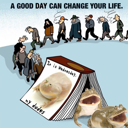

  0%|          | 0/61 [00:00<?, ?it/s]

на фото - карикатура: деньги, которые невозможно забыть
на фото - карикатура: деньги, которые вам не дают
на фото - карикатура: как я жил с вами в россии
на фото - депутаты госдумы от кпрф


In [ ]:
model.load_state_dict(torch.load('models/rudolph/rudolph__dalle_0.pt'))
model.eval()

template = 'на фото'
img = Image.open("data/memes/images/1.jpg").resize((128, 128))
captions_num = 4
display(img)

texts = generate_captions(img, tokenizer, model, vae, template=template, 
                          top_k=4, captions_num=captions_num, bs=16, top_p=0.6, seed=43, 
                          temperature=0.8, limit_eos=False)
ppl_text, ppl_image = self_reranking_by_image(texts, img, tokenizer, model, vae, bs=16, seed=42)
for idx in ppl_image.argsort()[:8]:
    print(texts[idx])

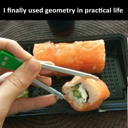

  0%|          | 0/61 [00:00<?, ?it/s]

на фото - как правильно выбрать суши
на фото - как правильно сушить рыбу в домашних условиях
на фото показаны способы приготовления роллов
на фото показаны три варианта приготовления суши


In [ ]:
model.eval()

template = 'на фото'

img = Image.open("data/memes/images/100.jpg").resize((128, 128))
captions_num = 4
display(img)

texts = generate_captions(img, tokenizer, model, vae, template=template, 
                          top_k=4, captions_num=captions_num, bs=16, top_p=0.6, seed=43, 
                          temperature=0.8, limit_eos=False)
ppl_text, ppl_image = self_reranking_by_image(texts, img, tokenizer, model, vae, bs=16, seed=42)
for idx in ppl_image.argsort()[:8]:
    print(texts[idx])

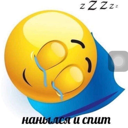

  0%|          | 0/61 [00:00<?, ?it/s]

на фото - набор для настольного тенниса
на фото - детский защитный шлем для катания на роликах, скейтборде, самокате
на фото - каска защитная строительная
на фото - каска защитная строительная с храповиком и вентиляцией


In [ ]:
model.eval()

template = 'на фото'

img = Image.open("data/memes/images/1000.jpg").resize((128, 128))
captions_num = 4
display(img)

texts = generate_captions(img, tokenizer, model, vae, template=template, 
                          top_k=4, captions_num=captions_num, bs=16, top_p=0.6, seed=43, 
                          temperature=0.8, limit_eos=False)
ppl_text, ppl_image = self_reranking_by_image(texts, img, tokenizer, model, vae, bs=16, seed=42)
for idx in ppl_image.argsort()[:8]:
    print(texts[idx])

## С дообучением

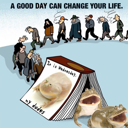

  0%|          | 0/61 [00:00<?, ?it/s]

на фото изображены люди в деловых костюмах и галстуках с галстуками и с сигаретой. на первом кадре изображены двое мужчин в очках с галстуками и с книгами в руках. они смотрят на читателя мема. подпись сверху: "давай, давай, давай". на втором кадре
на фото двое мужчин в камуфляжной форме сидят на кровати, держа в руках книгу и смотря на читателя мема. подпись сверху: "дайте мне денег".
на фото изображён человек в очках, сидя на кровати с читателем газеты и смотрящий на читателя мема. подпись сверху: "а что, это за человек?".
на фото изображены два человека в камуфляжной форме, которые читают книгу. один из них стоит на коленях, а второй держит книгу. подпись рядом: "да я не могу".


In [ ]:
model.load_state_dict(torch.load('models/rudolph/rudolph__dalle_best.pt'))
model.eval()

template = 'на фото'

img = Image.open("data/memes/images/1.jpg").resize((128, 128))
captions_num = 4
display(img)

texts = generate_captions(img, tokenizer, model, vae, template=template, 
                          top_k=4, captions_num=captions_num, bs=16, top_p=0.6, seed=43, 
                          temperature=0.8, limit_eos=False)
ppl_text, ppl_image = self_reranking_by_image(texts, img, tokenizer, model, vae, bs=16, seed=42)
for idx in ppl_image.argsort()[:8]:
    print(texts[idx])

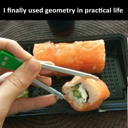

  0%|          | 0/61 [00:00<?, ?it/s]

на фото запечённый лосось в духовке. подпись: "ты не можешь поесть так как хочешь".
на фото изображен бутерброд с сыром и рукой. на его руке наложена черная этикетка. на этикетке написано: "me memes (кусок сыра)".
на фото рука держит суши ролл и держит палочку для еды. подпись на японском: "хочу суши ролл".
на фото запечённый лосось в духовке. подпись: "ты не можешь съесть лосося, но я не смогу".


In [ ]:
model.eval()

template = 'на фото'

img = Image.open("data/memes/images/100.jpg").resize((128, 128))
captions_num = 4
display(img)

texts = generate_captions(img, tokenizer, model, vae, template=template, 
                          top_k=4, captions_num=captions_num, bs=16, top_p=0.6, seed=43, 
                          temperature=0.8, limit_eos=False)
ppl_text, ppl_image = self_reranking_by_image(texts, img, tokenizer, model, vae, bs=16, seed=42)
for idx in ppl_image.argsort()[:8]:
    print(texts[idx])

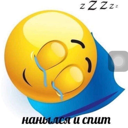

  0%|          | 0/61 [00:00<?, ?it/s]

на фото смайлик с улыбкой на лице, который улыбается и держит в руках ручку и блокнот. подпись сверху и снизу: "да это я".
на фото изображён смайлик с улыбкой на лице, смотрящий в сторону читателя мема. подпись: "да я не знаю".
на фото смайлик с сигаретой в носу и слёзами. подпись: "да я слышал о том, что в детстве ты играл в баскетбол".
на фото изображен смайлик с открытым ртом в синей шляпе. он улыбается и показывает пальцем на читателя мема. подпись: "ахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахаха


In [ ]:
model.eval()

template = 'на фото'

img = Image.open("data/memes/images/1000.jpg").resize((128, 128))
captions_num = 4
display(img)

texts = generate_captions(img, tokenizer, model, vae, template=template, 
                          top_k=4, captions_num=captions_num, bs=16, top_p=0.6, seed=43, 
                          temperature=0.8, limit_eos=False)
ppl_text, ppl_image = self_reranking_by_image(texts, img, tokenizer, model, vae, bs=16, seed=42)
for idx in ppl_image.argsort()[:8]:
    print(texts[idx])

Видно, что модель улавливает основные паттерны - ролл/сушина с лососем на картинке, люди в пиджаках. Иногда есть прямо хорошие описания, иногда похуже. Но совсем беда с подписями - их модель генерирует совсем рандомно, несмотря на то, что щаблон описаний она запомнила